In [ ]:
## STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats



In [ ]:
## STEP 2: LOAD DATA
from google.colab import files
uploaded = files.upload()



Saving bim_ai_civil engineering.csv to bim_ai_civil engineering.csv


In [ ]:
df = pd.read_csv('bim_ai_civil engineering.csv')


In [ ]:
##  Step 3: Basic EDA

# Shape of the dataset
print("Shape of dataset:", df.shape)

# Data types and non-null info
df.info()

# Summary statistics
df.describe()

# Missing values per column
print("\nMissing values:")
print(df.isnull().sum())


Shape of dataset: (1000, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Project_ID             1000 non-null   object 
 1   Project_Type           1000 non-null   object 
 2   Location               1000 non-null   object 
 3   Start_Date             1000 non-null   object 
 4   End_Date               1000 non-null   object 
 5   Planned_Cost           1000 non-null   int64  
 6   Actual_Cost            1000 non-null   float64
 7   Cost_Overrun           1000 non-null   float64
 8   Planned_Duration       1000 non-null   int64  
 9   Actual_Duration        1000 non-null   float64
 10  Schedule_Deviation     1000 non-null   float64
 11  Vibration_Level        1000 non-null   float64
 12  Crack_Width            1000 non-null   float64
 13  Load_Bearing_Capacity  1000 non-null   float64
 14  Temperature            1000 

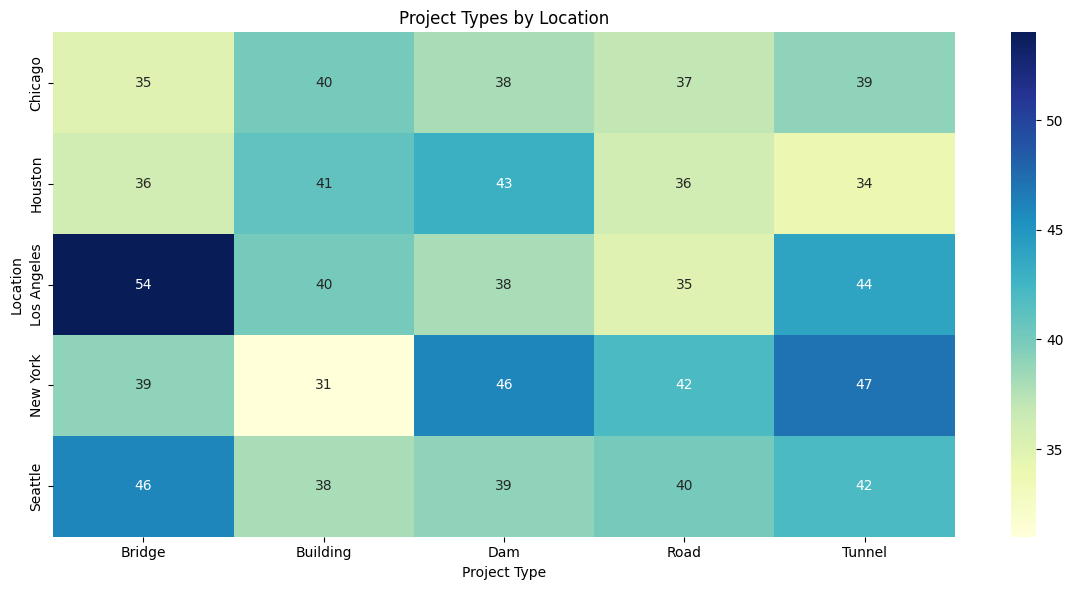

In [ ]:
## STEP 4: Project Type vs Location
location_project = df.groupby(['Location', 'Project_Type']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(location_project, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Project Types by Location")
plt.xlabel("Project Type")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

In [ ]:
##   Step 5: Convert Dates and Calculate Duration

# Convert date columns
df['Start_Date'] = pd.to_datetime(df['Start_Date'], errors='coerce')
df['End_Date'] = pd.to_datetime(df['End_Date'], errors='coerce')

# Calculate project duration in days
df['Duration_Days'] = (df['End_Date'] - df['Start_Date']).dt.days


In [ ]:
##  Step 6: Find Corner Cases

# Max and Min Cost
print("Max Actual Cost:", df['Actual_Cost'].max())
print("Min Actual Cost:", df['Actual_Cost'].min())

# Max and Min Duration
print("Max Duration (days):", df['Duration_Days'].max())
print("Min Duration (days):", df['Duration_Days'].min())

# Max Risk Level (if applicable)
if 'Risk_Level' in df.columns:
    print("Unique Risk Levels:", df['Risk_Level'].unique())


Max Actual Cost: 72519386.55
Min Actual Cost: 1180251.528
Max Duration (days): 897
Min Duration (days): 180
Unique Risk Levels: ['High' 'Low' 'Medium']


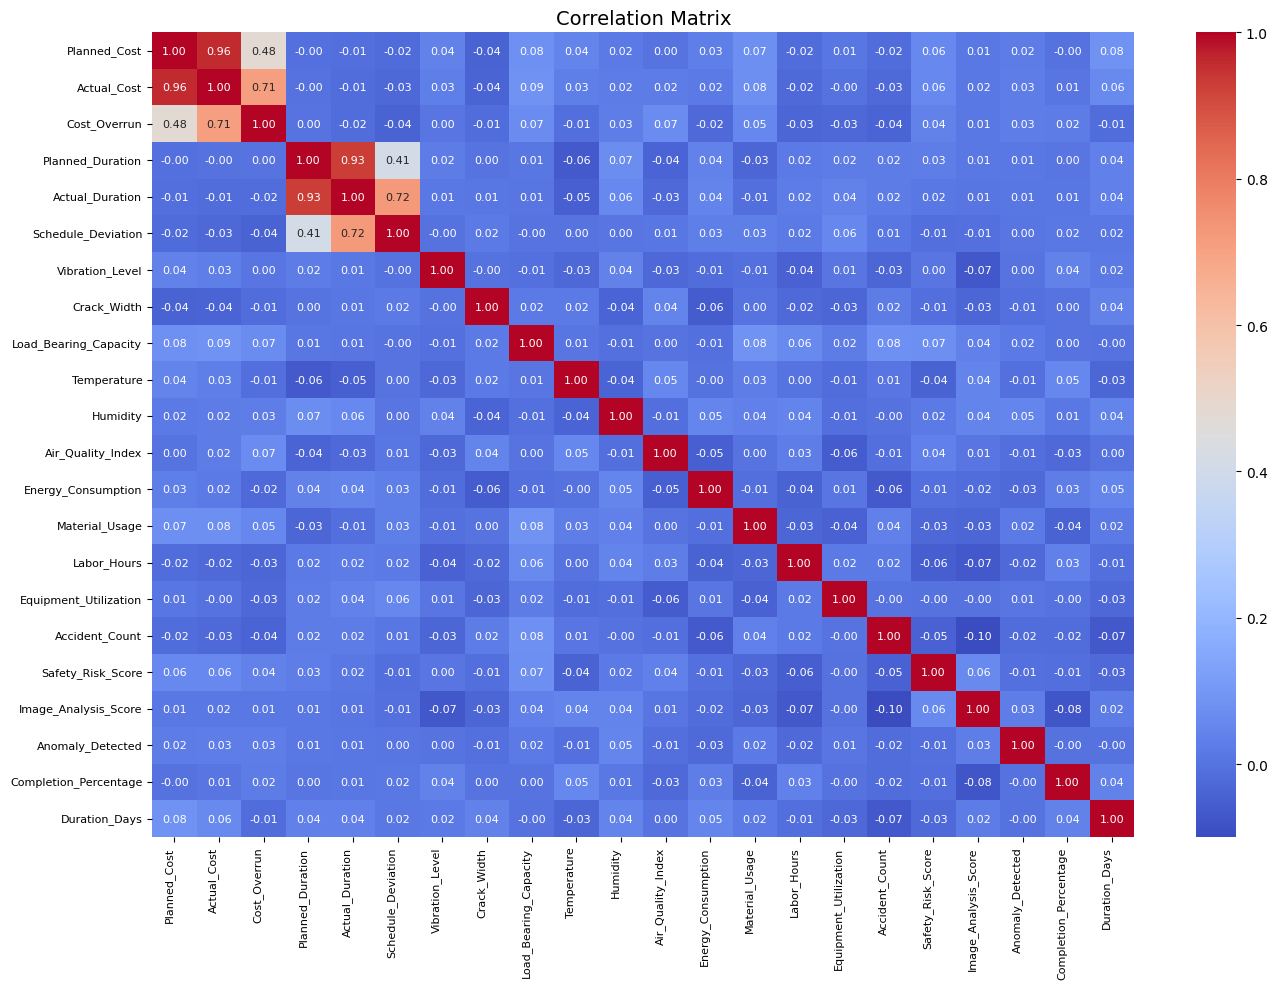

In [ ]:
##  Step 7: Correlation Matrix (Visualization)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))  # Set the figure size

heatmap = sns.heatmap(
    df.corr(numeric_only=True),  # Compute correlation for numeric columns only
    annot=True,                  # Show the correlation coefficients
    fmt=".2f",                   # Format numbers to 2 decimal places
    cmap='coolwarm',            # Color map from blue (negative) to red (positive)
    annot_kws={"size": 8},      # Font size for annotations inside cells
    cbar=True                   # Show the color bar
)

plt.title("Correlation Matrix", fontsize=14)          # Set the title
plt.xticks(rotation=90, ha='right', fontsize=8)       # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=8)                    # Keep y-axis labels horizontal
plt.tight_layout()                                    # Adjust layout to prevent overlap
plt.show()                                            # Display the plot



Mean Squared Error: 31,698,900,238,159.11
R2 Score: 0.03


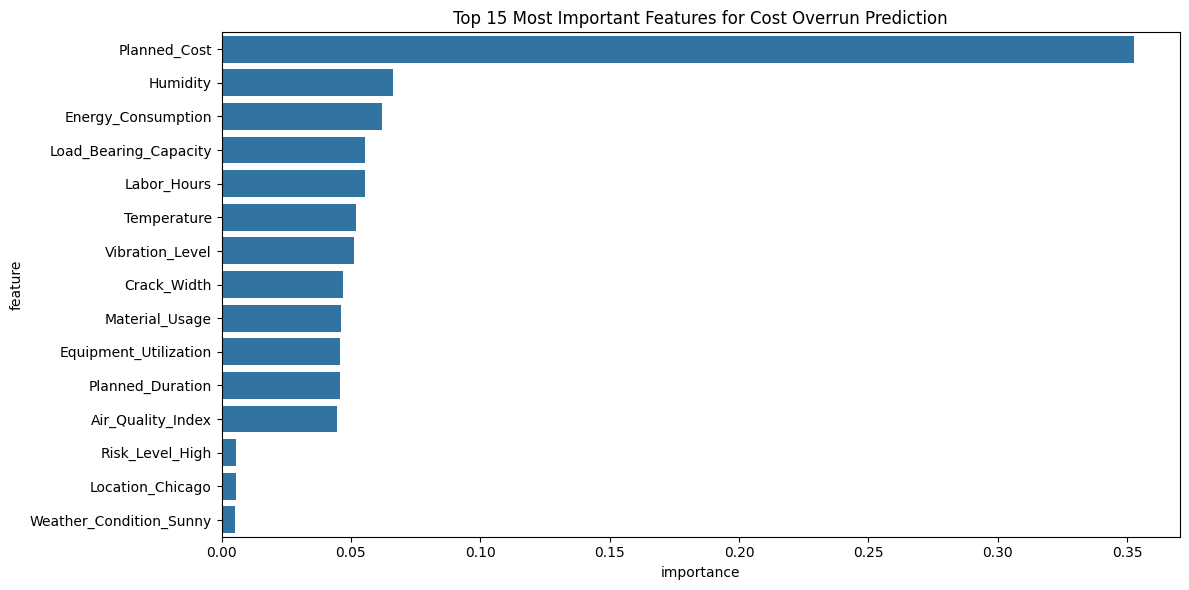

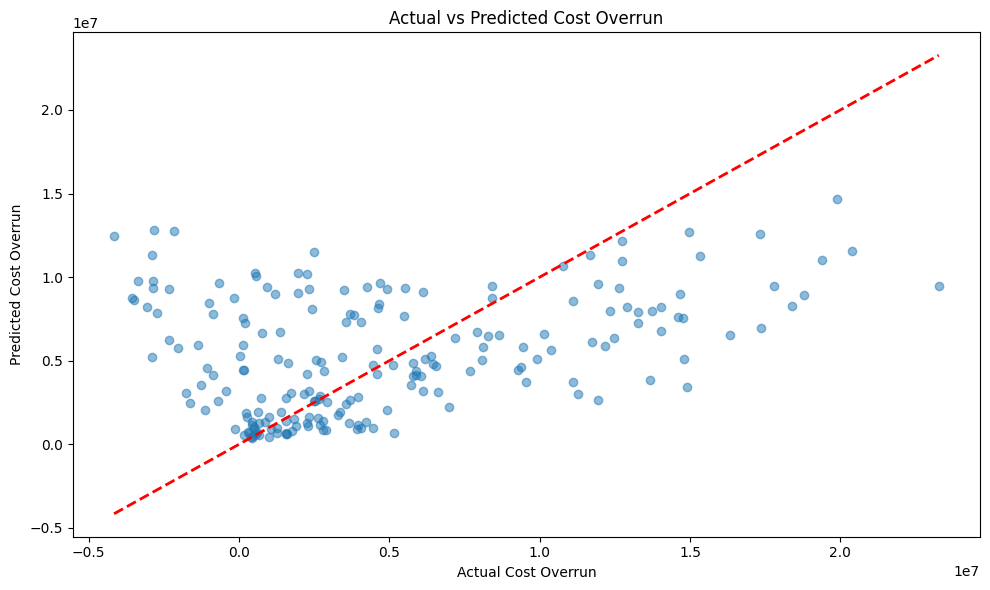

['cost_overrun_model.joblib']

In [ ]:
## STEP 8: Top 15 Most Important Features for Cost Overrun Prediction & Actual vs Predicted Cost Overrun

# Prepare features and target
categorical_features = ['Project_Type', 'Location', 'Weather_Condition', 'Risk_Level']
numerical_features = ['Planned_Cost', 'Planned_Duration', 'Vibration_Level',
                     'Crack_Width', 'Load_Bearing_Capacity', 'Temperature',
                     'Humidity', 'Air_Quality_Index', 'Energy_Consumption',
                     'Material_Usage', 'Labor_Hours', 'Equipment_Utilization']

X = df[categorical_features + numerical_features]
y = df['Cost_Overrun']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:,.2f}")
print(f"R2 Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': numerical_features + [f"{cat}_{val}" for cat, vals in
              zip(categorical_features, model.named_steps['preprocessor']
                  .named_transformers_['cat'].categories_) for val in vals],
    'importance': model.named_steps['regressor'].feature_importances_
})

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature',
            data=feature_importance.sort_values('importance', ascending=False).head(15))
plt.title('Top 15 Most Important Features for Cost Overrun Prediction')
plt.tight_layout()
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Cost Overrun')
plt.ylabel('Predicted Cost Overrun')
plt.title('Actual vs Predicted Cost Overrun')
plt.tight_layout()
plt.show()

# Save the model
import joblib
joblib.dump(model, 'cost_overrun_model.joblib')


=== Basic Cost Analysis ===

Cost Statistics (in millions):
       Planned_Cost  Actual_Cost  Cost_Overrun
count      0.001000     0.001000      0.001000
mean      26.415088    31.541079      5.125992
std       14.485762    18.095959      5.931350
min        1.045475     1.180252     -4.648579
25%       14.310133    16.096547      0.581066
50%       26.908602    31.339224      3.326817
75%       39.570293    45.327469      8.665132
max       49.968538    72.519387     24.012292

=== Duration Analysis ===

Duration Statistics (in days):
       Planned_Duration  Actual_Duration  Schedule_Deviation
count       1000.000000      1000.000000         1000.000000
mean         538.620000       645.560751          106.940751
std          204.531765       269.383931          110.387587
min          180.000000       165.278211          -79.136491
25%          361.000000       424.252757           22.402402
50%          535.500000       635.469136           84.056607
75%          713.000000       

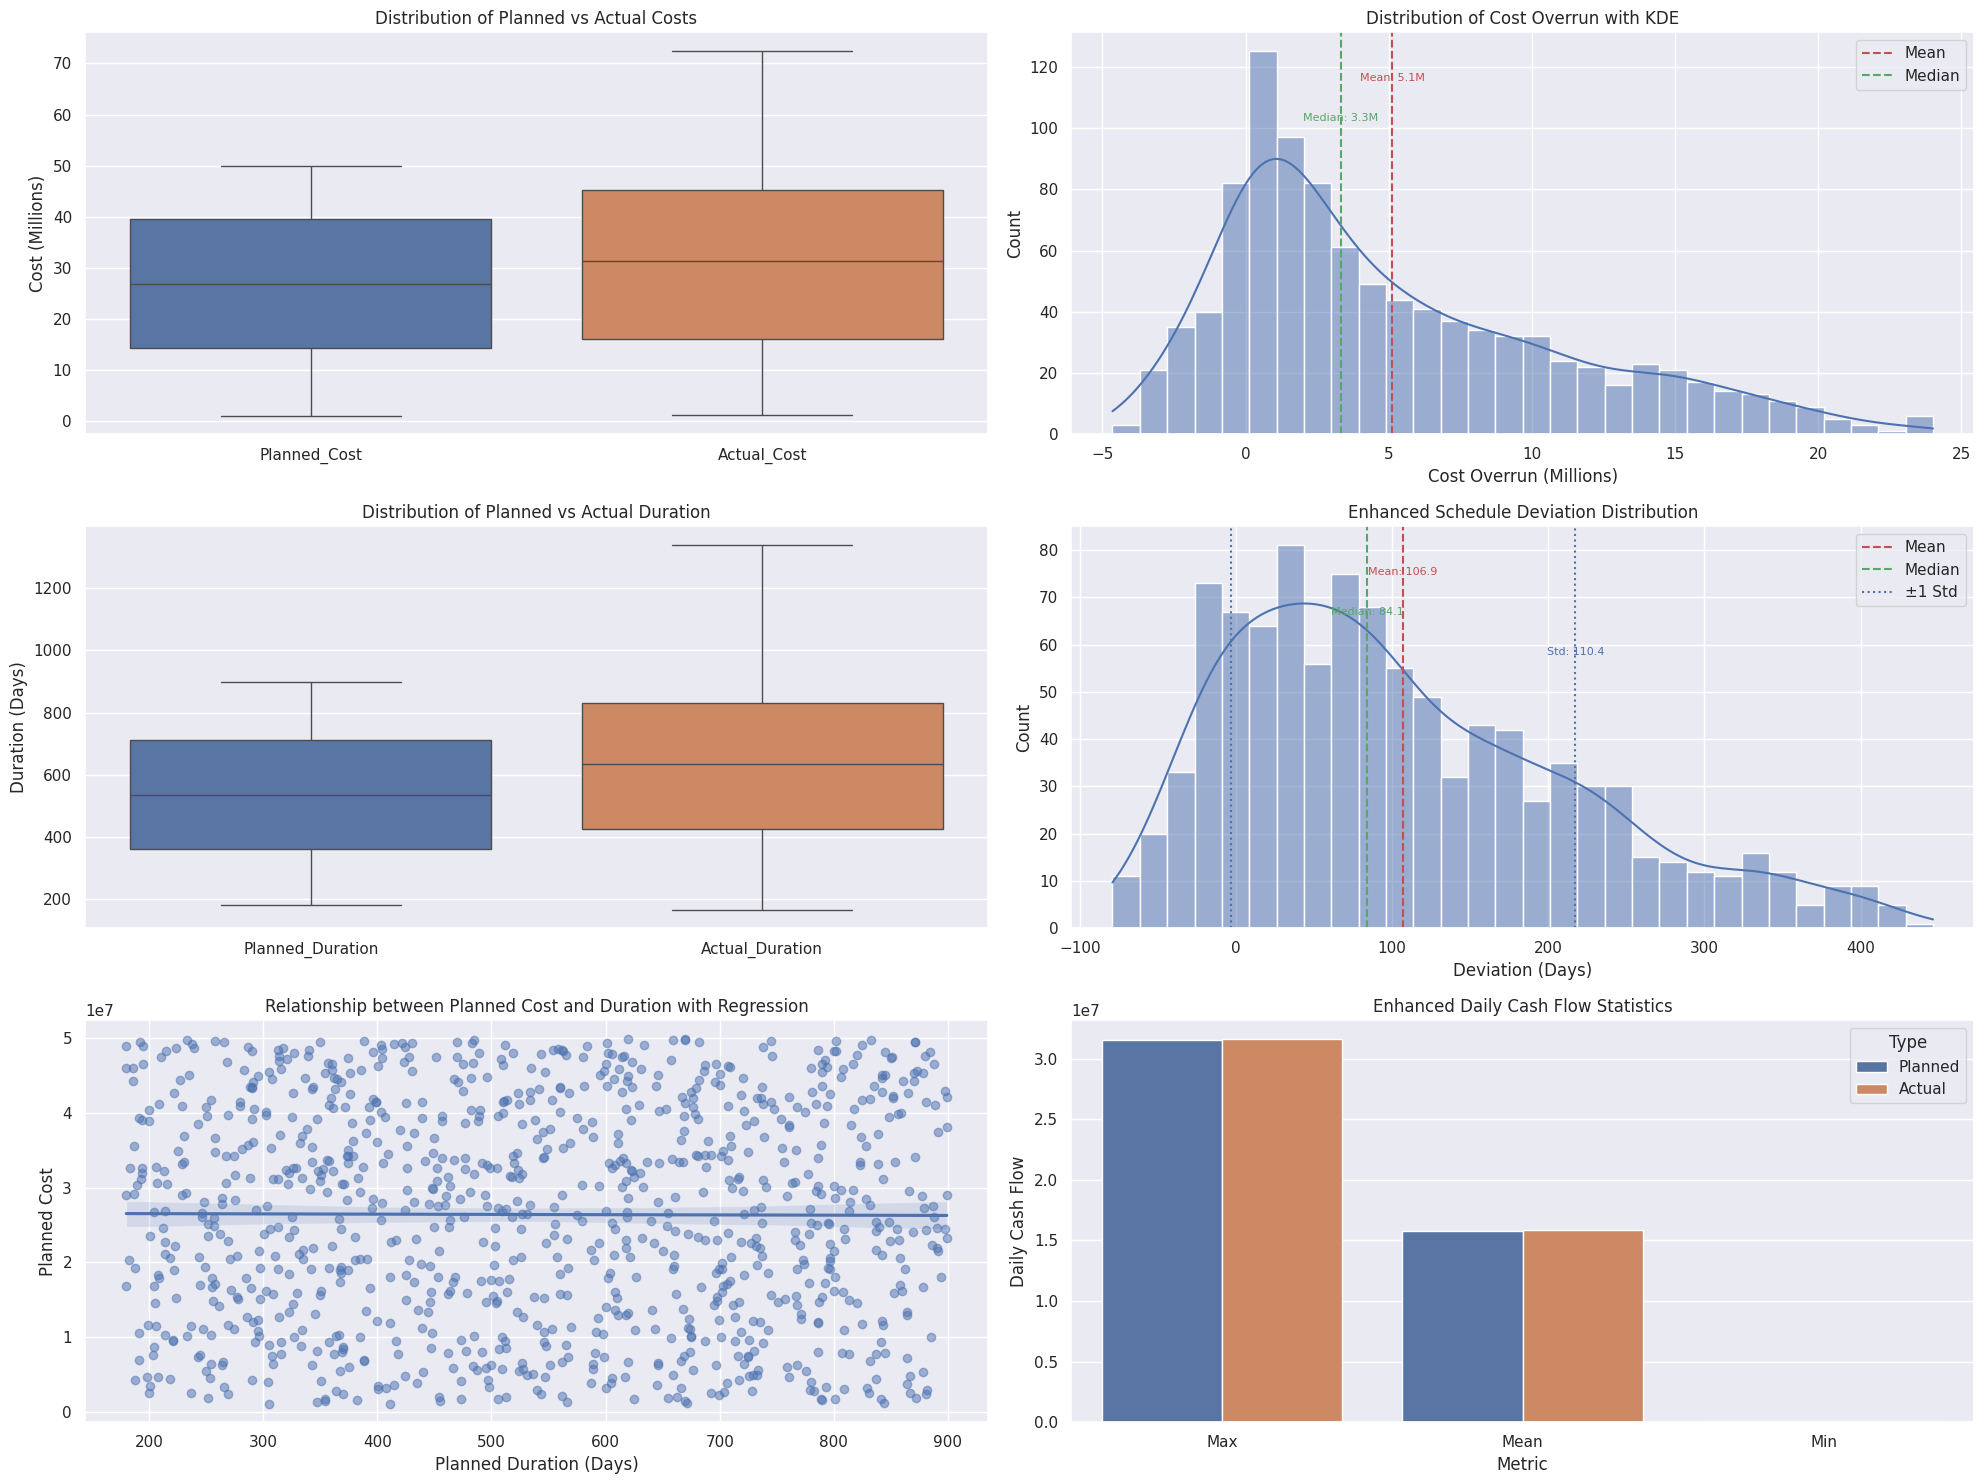

<ipython-input-12-b5994140b2e3>:152: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  project_cash_flow = df.groupby('Project_Type').apply(lambda x: x['Daily_Actual_Cost'].mean())


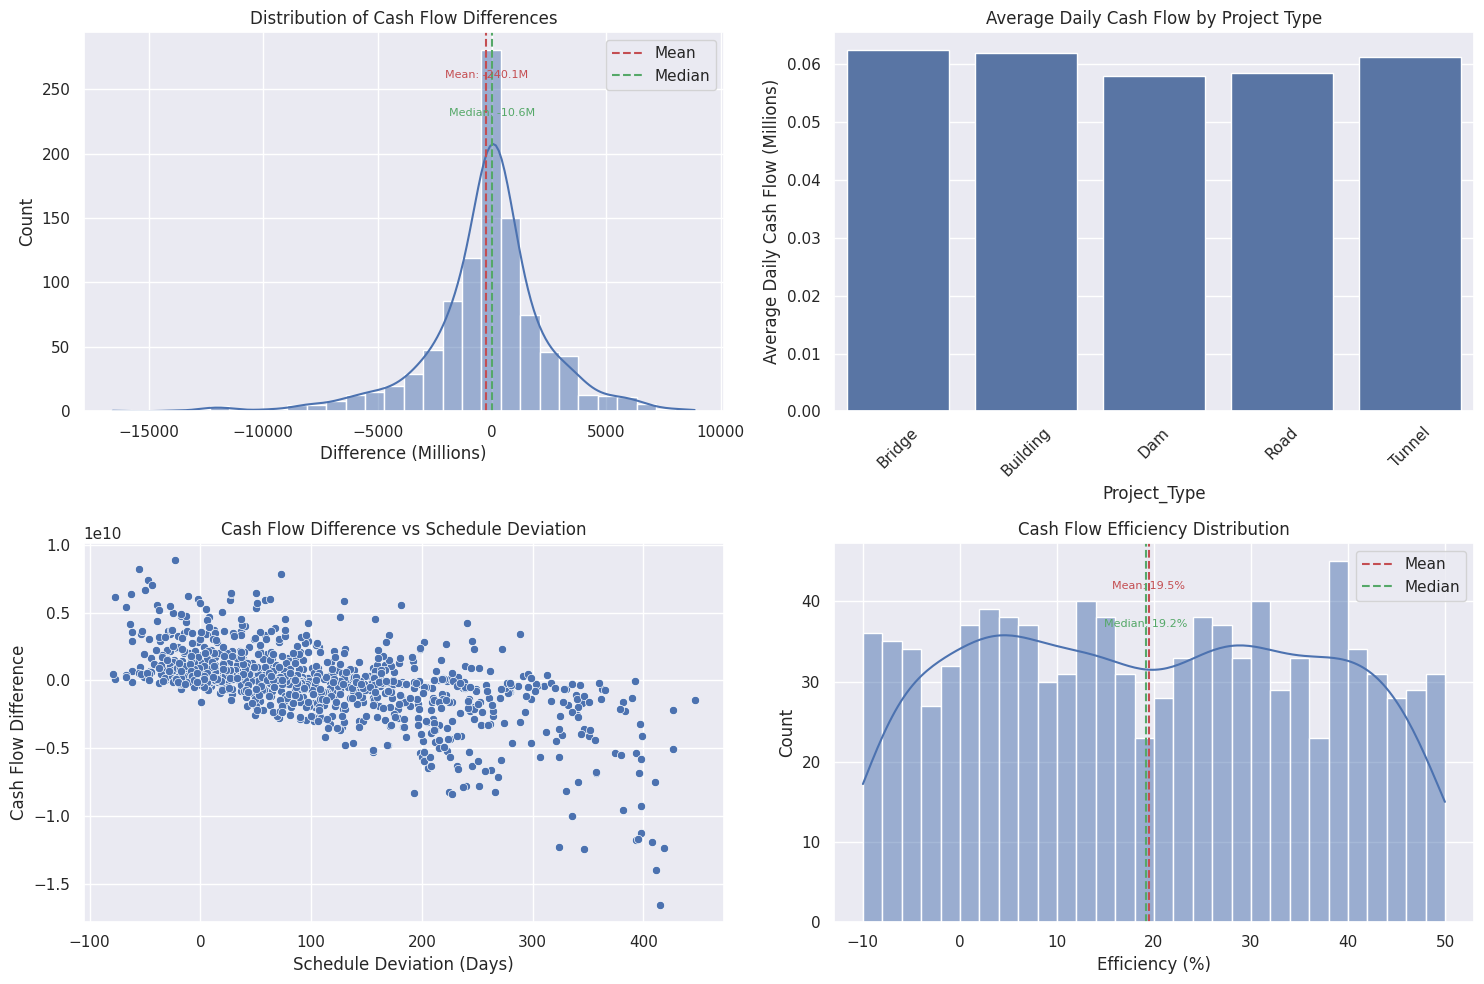


=== Additional Cash Flow Statistics ===

Daily Cash Flow Statistics (in millions):
               Metric    Planned     Actual
0             Maximum  31.531004  31.571536
1             Minimum   0.058927   0.060403
2                Mean  15.794966  15.815969
3              Median  15.667104  15.711423
4  Standard Deviation   9.052999   9.074001

Schedule Deviation Statistics (in days):
               Metric       Value
0             Maximum  446.352531
1             Minimum  -79.136491
2                Mean  106.940751
3              Median   84.056607
4  Standard Deviation  110.387587


In [ ]:
## STEP 9-1: Cash_Flow
# Set style
plt.style.use('default')
sns.set_theme()

# Convert dates to datetime
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['End_Date'] = pd.to_datetime(df['End_Date'])

# 1. Basic Cost Analysis
print("\n=== Basic Cost Analysis ===")
cost_stats = df[['Planned_Cost', 'Actual_Cost', 'Cost_Overrun']].describe()
print("\nCost Statistics (in millions):")
print(cost_stats / 1000000)

# 2. Duration Analysis
print("\n=== Duration Analysis ===")
duration_stats = df[['Planned_Duration', 'Actual_Duration', 'Schedule_Deviation']].describe()
print("\nDuration Statistics (in days):")
print(duration_stats)

# 3. Enhanced Cash Flow Analysis
df['Daily_Planned_Cost'] = df['Planned_Cost'] / df['Planned_Duration']
df['Daily_Actual_Cost'] = df['Actual_Cost'] / df['Actual_Duration']

def calculate_enhanced_cash_flow(row):
    days = np.arange(1, row['Actual_Duration'] + 1)
    planned_cash = days * row['Daily_Planned_Cost']
    actual_cash = days * row['Daily_Actual_Cost']

    # Calculate cumulative cash flow
    cumulative_planned = np.cumsum(planned_cash)
    cumulative_actual = np.cumsum(actual_cash)

    return pd.Series({
        'Planned_Cash_Flow': cumulative_planned[-1],
        'Actual_Cash_Flow': cumulative_actual[-1],
        'Cash_Flow_Difference': cumulative_actual[-1] - cumulative_planned[-1],
        'Max_Daily_Planned': np.max(planned_cash),
        'Min_Daily_Planned': np.min(planned_cash),
        'Mean_Daily_Planned': np.mean(planned_cash),
        'Max_Daily_Actual': np.max(actual_cash),
        'Min_Daily_Actual': np.min(actual_cash),
        'Mean_Daily_Actual': np.mean(actual_cash)
    })

cash_flow = df.apply(calculate_enhanced_cash_flow, axis=1)
print("\n=== Enhanced Cash Flow Analysis ===")
print("\nCash Flow Statistics (in millions):")
print(cash_flow.describe() / 1000000)

# 4. Enhanced Visualizations
fig = plt.figure(figsize=(20, 15))

# Cost Distribution
plt.subplot(3, 2, 1)
sns.boxplot(data=df[['Planned_Cost', 'Actual_Cost']] / 1000000)
plt.title('Distribution of Planned vs Actual Costs')
plt.ylabel('Cost (Millions)')

# Enhanced Cost Overrun Distribution with KDE
plt.subplot(3, 2, 2)
sns.histplot(df['Cost_Overrun'] / 1000000, bins=30, kde=True)
mean_cost = df['Cost_Overrun'].mean() / 1000000
median_cost = df['Cost_Overrun'].median() / 1000000
plt.axvline(mean_cost, color='r', linestyle='--', label='Mean')
plt.axvline(median_cost, color='g', linestyle='--', label='Median')
plt.text(mean_cost, plt.ylim()[1]*0.9, f'Mean: {mean_cost:.1f}M',
         color='r', ha='center', va='top', fontsize=8)
plt.text(median_cost, plt.ylim()[1]*0.8, f'Median: {median_cost:.1f}M',
         color='g', ha='center', va='top', fontsize=8)
plt.title('Distribution of Cost Overrun with KDE')
plt.xlabel('Cost Overrun (Millions)')
plt.legend()

# Duration Distribution
plt.subplot(3, 2, 3)
sns.boxplot(data=df[['Planned_Duration', 'Actual_Duration']])
plt.title('Distribution of Planned vs Actual Duration')
plt.ylabel('Duration (Days)')

# Enhanced Schedule Deviation Distribution with KDE and Statistics
plt.subplot(3, 2, 4)
sns.histplot(df['Schedule_Deviation'], bins=30, kde=True)
mean_dev = df['Schedule_Deviation'].mean()
median_dev = df['Schedule_Deviation'].median()
std_dev = df['Schedule_Deviation'].std()
plt.axvline(mean_dev, color='r', linestyle='--', label='Mean')
plt.axvline(median_dev, color='g', linestyle='--', label='Median')
plt.axvline(mean_dev + std_dev, color='b', linestyle=':', label='±1 Std')
plt.axvline(mean_dev - std_dev, color='b', linestyle=':')
plt.text(mean_dev, plt.ylim()[1]*0.9, f'Mean: {mean_dev:.1f}',
         color='r', ha='center', va='top', fontsize=8)
plt.text(median_dev, plt.ylim()[1]*0.8, f'Median: {median_dev:.1f}',
         color='g', ha='center', va='top', fontsize=8)
plt.text(mean_dev + std_dev, plt.ylim()[1]*0.7, f'Std: {std_dev:.1f}',
         color='b', ha='center', va='top', fontsize=8)
plt.title('Enhanced Schedule Deviation Distribution')
plt.xlabel('Deviation (Days)')
plt.legend()

# Cost vs Duration with Regression Line
plt.subplot(3, 2, 5)
sns.regplot(x='Planned_Duration', y='Planned_Cost', data=df, scatter_kws={'alpha':0.5})
plt.title('Relationship between Planned Cost and Duration with Regression')
plt.xlabel('Planned Duration (Days)')
plt.ylabel('Planned Cost')

# Enhanced Cash Flow Analysis with Daily Statistics
plt.subplot(3, 2, 6)
cash_flow_data = pd.DataFrame({
    'Type': ['Planned', 'Actual'] * 3,
    'Metric': ['Max', 'Max', 'Mean', 'Mean', 'Min', 'Min'],
    'Value': [
        cash_flow['Max_Daily_Planned'].mean(),
        cash_flow['Max_Daily_Actual'].mean(),
        cash_flow['Mean_Daily_Planned'].mean(),
        cash_flow['Mean_Daily_Actual'].mean(),
        cash_flow['Min_Daily_Planned'].mean(),
        cash_flow['Min_Daily_Actual'].mean()
    ]
})
sns.barplot(x='Metric', y='Value', hue='Type', data=cash_flow_data)
plt.title('Enhanced Daily Cash Flow Statistics')
plt.ylabel('Daily Cash Flow')

plt.tight_layout()
plt.show()

# 5. Additional Cash Flow Analysis
plt.figure(figsize=(15, 10))

# Cumulative Cash Flow Distribution
plt.subplot(2, 2, 1)
sns.histplot(cash_flow['Cash_Flow_Difference'] / 1000000, bins=30, kde=True)
mean_diff = cash_flow['Cash_Flow_Difference'].mean() / 1000000
median_diff = cash_flow['Cash_Flow_Difference'].median() / 1000000
plt.axvline(mean_diff, color='r', linestyle='--', label='Mean')
plt.axvline(median_diff, color='g', linestyle='--', label='Median')
plt.text(mean_diff, plt.ylim()[1]*0.9, f'Mean: {mean_diff:.1f}M',
         color='r', ha='center', va='top', fontsize=8)
plt.text(median_diff, plt.ylim()[1]*0.8, f'Median: {median_diff:.1f}M',
         color='g', ha='center', va='top', fontsize=8)
plt.title('Distribution of Cash Flow Differences')
plt.xlabel('Difference (Millions)')
plt.legend()

# Daily Cash Flow Statistics by Project Type
plt.subplot(2, 2, 2)
project_cash_flow = df.groupby('Project_Type').apply(lambda x: x['Daily_Actual_Cost'].mean())
sns.barplot(x=project_cash_flow.index, y=project_cash_flow.values / 1000000)
plt.title('Average Daily Cash Flow by Project Type')
plt.xticks(rotation=45)
plt.ylabel('Average Daily Cash Flow (Millions)')

# Cash Flow vs Schedule Deviation
plt.subplot(2, 2, 3)
sns.scatterplot(x='Schedule_Deviation', y='Cash_Flow_Difference',
                data=pd.concat([df['Schedule_Deviation'], cash_flow['Cash_Flow_Difference']], axis=1))
plt.title('Cash Flow Difference vs Schedule Deviation')
plt.xlabel('Schedule Deviation (Days)')
plt.ylabel('Cash Flow Difference')

# Cash Flow Efficiency
plt.subplot(2, 2, 4)
efficiency = (df['Actual_Cost'] - df['Planned_Cost']) / df['Planned_Cost'] * 100
sns.histplot(efficiency, bins=30, kde=True)
mean_eff = efficiency.mean()
median_eff = efficiency.median()
plt.axvline(mean_eff, color='r', linestyle='--', label='Mean')
plt.axvline(median_eff, color='g', linestyle='--', label='Median')
plt.text(mean_eff, plt.ylim()[1]*0.9, f'Mean: {mean_eff:.1f}%',
         color='r', ha='center', va='top', fontsize=8)
plt.text(median_eff, plt.ylim()[1]*0.8, f'Median: {median_eff:.1f}%',
         color='g', ha='center', va='top', fontsize=8)
plt.title('Cash Flow Efficiency Distribution')
plt.xlabel('Efficiency (%)')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Print Additional Statistics
print("\n=== Additional Cash Flow Statistics ===")
print("\nDaily Cash Flow Statistics (in millions):")
daily_stats = pd.DataFrame({
    'Metric': ['Maximum', 'Minimum', 'Mean', 'Median', 'Standard Deviation'],
    'Planned': [
        cash_flow['Max_Daily_Planned'].mean() / 1000000,
        cash_flow['Min_Daily_Planned'].mean() / 1000000,
        cash_flow['Mean_Daily_Planned'].mean() / 1000000,
        cash_flow['Mean_Daily_Planned'].median() / 1000000,
        cash_flow['Mean_Daily_Planned'].std() / 1000000
    ],
    'Actual': [
        cash_flow['Max_Daily_Actual'].mean() / 1000000,
        cash_flow['Min_Daily_Actual'].mean() / 1000000,
        cash_flow['Mean_Daily_Actual'].mean() / 1000000,
        cash_flow['Mean_Daily_Actual'].median() / 1000000,
        cash_flow['Mean_Daily_Actual'].std() / 1000000
    ]
})
print(daily_stats)

print("\nSchedule Deviation Statistics (in days):")
schedule_stats = pd.DataFrame({
    'Metric': ['Maximum', 'Minimum', 'Mean', 'Median', 'Standard Deviation'],
    'Value': [
        df['Schedule_Deviation'].max(),
        df['Schedule_Deviation'].min(),
        df['Schedule_Deviation'].mean(),
        df['Schedule_Deviation'].median(),
        df['Schedule_Deviation'].std()
    ]
})
print(schedule_stats)


=== Cash Flow Statistics by Project Type (in millions) ===

Tunnel:
               Metric    Planned     Actual
0             Maximum  74.142626  71.510715
1             Minimum   1.269190   1.322072
2                Mean  33.093956  33.016724
3              Median  33.566203  32.424198
4  Standard Deviation  17.221850  17.148143
Average Efficiency: -0.2%

Dam:
               Metric    Planned     Actual
0             Maximum  70.296581  72.685727
1             Minimum   1.463835   1.181147
2                Mean  29.247116  29.933681
3              Median  28.592446  27.867092
4  Standard Deviation  18.159743  18.881249
Average Efficiency: 2.3%

Building:
               Metric    Planned     Actual
0             Maximum  69.944694  69.458640
1             Minimum   1.574966   1.462556
2                Mean  33.618247  33.111844
3              Median  35.734744  35.303770
4  Standard Deviation  18.531800  18.641171
Average Efficiency: -1.5%

Road:
               Metric    Planned     A

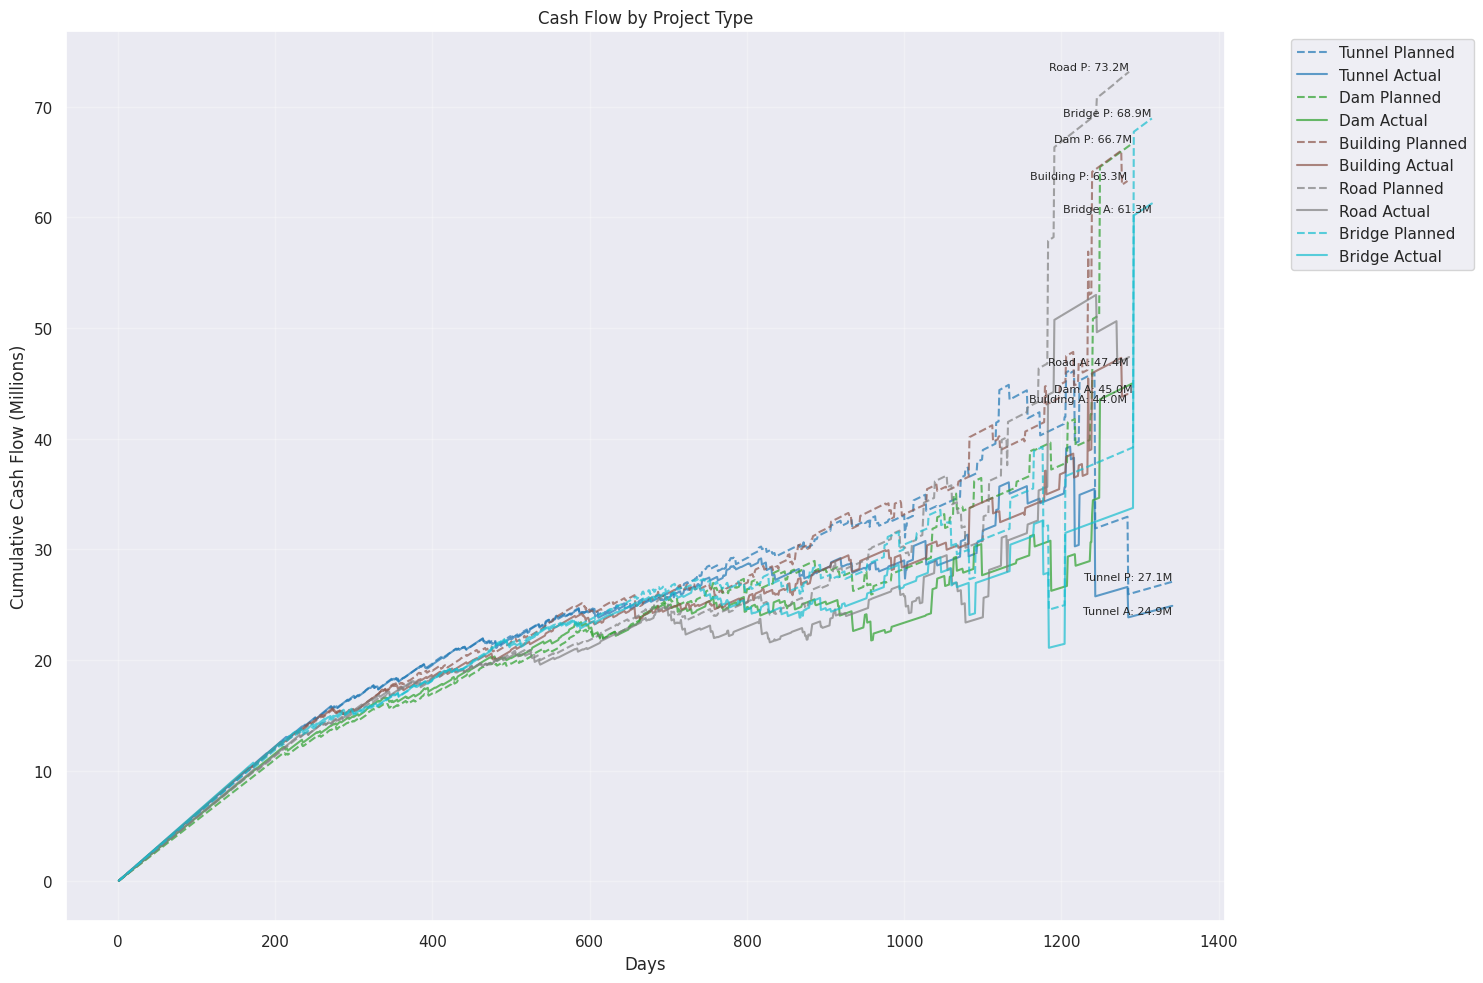

In [ ]:
## STEP 9-2: Cash_Flow

# Set style
plt.style.use('default')
sns.set_theme()

# Convert dates to datetime
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['End_Date'] = pd.to_datetime(df['End_Date'])

# Calculate daily cash flow for each project
def calculate_project_cash_flow(row):
    days = np.arange(1, row['Actual_Duration'] + 1)
    planned_daily = row['Planned_Cost'] / row['Planned_Duration']
    actual_daily = row['Actual_Cost'] / row['Actual_Duration']

    planned_cumulative = np.cumsum([planned_daily] * len(days))
    actual_cumulative = np.cumsum([actual_daily] * len(days))

    return pd.Series({
        'Days': days,
        'Planned_Cumulative': planned_cumulative,
        'Actual_Cumulative': actual_cumulative,
        'Project_ID': row['Project_ID'],
        'Project_Type': row['Project_Type']
    })

# Calculate cash flow for all projects
cash_flow_data = []
for _, row in df.iterrows():
    cf = calculate_project_cash_flow(row)
    cash_flow_data.append(cf)

# Create a new figure for cash flow analysis
plt.figure(figsize=(15, 10))

# Plot cash flow by project type
project_types = df['Project_Type'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(project_types)))

for i, ptype in enumerate(project_types):
    # Get projects of this type
    project_cf = [cf for cf in cash_flow_data if cf['Project_Type'] == ptype]

    # Calculate average cash flow for this project type
    max_days = max(len(cf['Days']) for cf in project_cf)
    avg_planned = np.zeros(max_days)
    avg_actual = np.zeros(max_days)
    count = np.zeros(max_days)

    for cf in project_cf:
        days = cf['Days']
        avg_planned[:len(days)] += cf['Planned_Cumulative']
        avg_actual[:len(days)] += cf['Actual_Cumulative']
        count[:len(days)] += 1

    # Calculate average
    avg_planned = avg_planned / np.maximum(count, 1)
    avg_actual = avg_actual / np.maximum(count, 1)
    days = np.arange(1, max_days + 1)

    # Plot planned and actual cash flow
    plt.plot(days, avg_planned / 1000000, '--', color=colors[i],
             alpha=0.7, label=f'{ptype} Planned')
    plt.plot(days, avg_actual / 1000000, '-', color=colors[i],
             alpha=0.7, label=f'{ptype} Actual')

    # Add final values
    plt.text(days[-1], avg_planned[-1] / 1000000,
             f'{ptype} P: {avg_planned[-1] / 1000000:.1f}M',
             ha='right', va='bottom', fontsize=8)
    plt.text(days[-1], avg_actual[-1] / 1000000,
             f'{ptype} A: {avg_actual[-1] / 1000000:.1f}M',
             ha='right', va='top', fontsize=8)

plt.title('Cash Flow by Project Type')
plt.xlabel('Days')
plt.ylabel('Cumulative Cash Flow (Millions)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add statistics for each project type
print("\n=== Cash Flow Statistics by Project Type (in millions) ===")
for ptype in project_types:
    project_cf = [cf for cf in cash_flow_data if cf['Project_Type'] == ptype]
    final_planned = [cf['Planned_Cumulative'][-1] for cf in project_cf]
    final_actual = [cf['Actual_Cumulative'][-1] for cf in project_cf]

    print(f"\n{ptype}:")
    stats_df = pd.DataFrame({
        'Metric': ['Maximum', 'Minimum', 'Mean', 'Median', 'Standard Deviation'],
        'Planned': [
            np.max(final_planned) / 1000000,
            np.min(final_planned) / 1000000,
            np.mean(final_planned) / 1000000,
            np.median(final_planned) / 1000000,
            np.std(final_planned) / 1000000
        ],
        'Actual': [
            np.max(final_actual) / 1000000,
            np.min(final_actual) / 1000000,
            np.mean(final_actual) / 1000000,
            np.median(final_actual) / 1000000,
            np.std(final_actual) / 1000000
        ]
    })
    print(stats_df)

    # Calculate efficiency
    efficiency = (np.mean(final_actual) - np.mean(final_planned)) / np.mean(final_planned) * 100
    print(f"Average Efficiency: {efficiency:.1f}%")

plt.tight_layout()
plt.show()

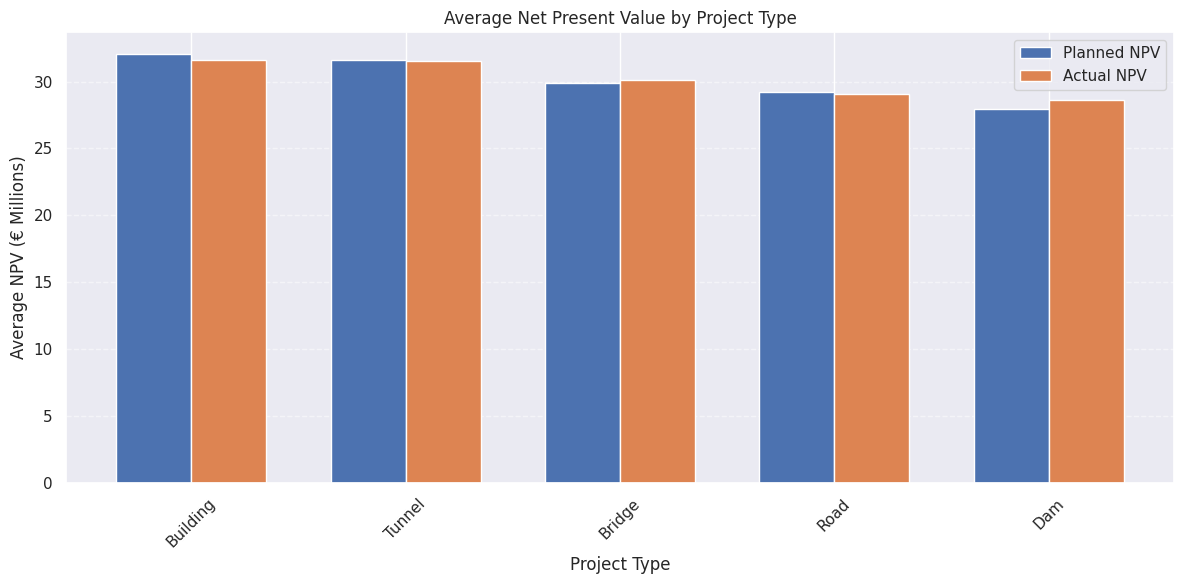

In [ ]:
## STEP 10-1: NPV

# Step 1: Define discount rate
annual_discount_rate = 0.05
daily_discount_rate = (1 + annual_discount_rate) ** (1/365) - 1

# Step 2: Calculate NPV per project
def calculate_project_npv(row):
    duration = int(row['Actual_Duration'])
    if duration <= 0:
        return pd.Series({
            'Project_ID': row['Project_ID'],
            'Project_Type': row['Project_Type'],
            'NPV_Planned': np.nan,
            'NPV_Actual': np.nan
        })

    days = np.arange(1, duration + 1)
    planned_daily = row['Planned_Cost'] / row['Planned_Duration']
    actual_daily = row['Actual_Cost'] / row['Actual_Duration']

    npv_planned = np.sum(planned_daily / ((1 + daily_discount_rate) ** days))
    npv_actual = np.sum(actual_daily / ((1 + daily_discount_rate) ** days))

    return pd.Series({
        'Project_ID': row['Project_ID'],
        'Project_Type': row['Project_Type'],
        'NPV_Planned': npv_planned,
        'NPV_Actual': npv_actual
    })

npv_df = df.apply(calculate_project_npv, axis=1)

# Step 3: Group by Project_Type and calculate average
grouped_npv = npv_df.groupby('Project_Type')[['NPV_Planned', 'NPV_Actual']].mean() / 1_000_000  # in millions
grouped_npv['NPV_Diff'] = grouped_npv['NPV_Actual'] - grouped_npv['NPV_Planned']

# Step 4: Plot
grouped_npv_sorted = grouped_npv.sort_values('NPV_Actual', ascending=False)

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(grouped_npv_sorted))

plt.bar(index, grouped_npv_sorted['NPV_Planned'], bar_width, label='Planned NPV')
plt.bar(index + bar_width, grouped_npv_sorted['NPV_Actual'], bar_width, label='Actual NPV')

plt.xlabel('Project Type')
plt.ylabel('Average NPV (€ Millions)')
plt.title('Average Net Present Value by Project Type')
plt.xticks(index + bar_width / 2, grouped_npv_sorted.index, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


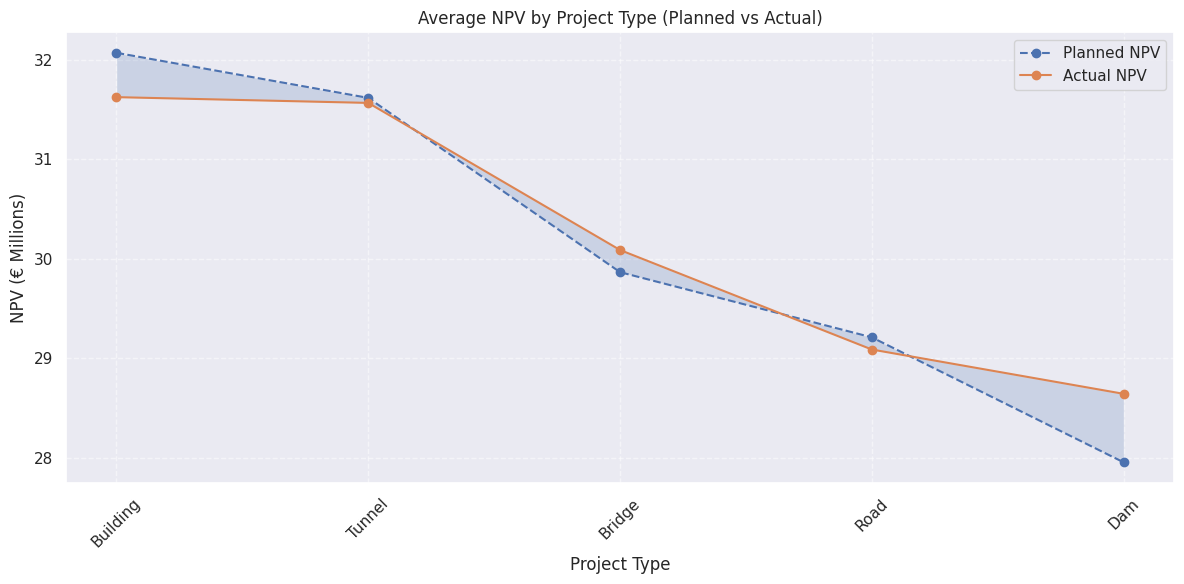


📊 === NPV Summary Report by Project Type ===

- Building:
  Planned NPV     = 32.07 M€
  Actual NPV      = 31.63 M€
  Difference      = -0.45 M€
  Efficiency      = -1.4%

- Tunnel:
  Planned NPV     = 31.62 M€
  Actual NPV      = 31.57 M€
  Difference      = -0.05 M€
  Efficiency      = -0.2%

- Bridge:
  Planned NPV     = 29.86 M€
  Actual NPV      = 30.09 M€
  Difference      = 0.22 M€
  Efficiency      = 0.7%

- Road:
  Planned NPV     = 29.21 M€
  Actual NPV      = 29.09 M€
  Difference      = -0.12 M€
  Efficiency      = -0.4%

- Dam:
  Planned NPV     = 27.95 M€
  Actual NPV      = 28.64 M€
  Difference      = 0.69 M€
  Efficiency      = 2.5%



In [ ]:
## STEP 10-2: NPV

#Next follow-up to calculate NPV
annual_discount_rate = 0.05
daily_discount_rate = (1 + annual_discount_rate) ** (1/365) - 1

def calculate_project_npv(row):
    duration = int(row['Actual_Duration'])
    if duration <= 0:
        return pd.Series({
            'Project_ID': row['Project_ID'],
            'Project_Type': row['Project_Type'],
            'NPV_Planned': np.nan,
            'NPV_Actual': np.nan
        })

    days = np.arange(1, duration + 1)
    planned_daily = row['Planned_Cost'] / row['Planned_Duration']
    actual_daily = row['Actual_Cost'] / row['Actual_Duration']

    npv_planned = np.sum(planned_daily / ((1 + daily_discount_rate) ** days))
    npv_actual = np.sum(actual_daily / ((1 + daily_discount_rate) ** days))

    return pd.Series({
        'Project_ID': row['Project_ID'],
        'Project_Type': row['Project_Type'],
        'NPV_Planned': npv_planned,
        'NPV_Actual': npv_actual
    })

npv_df = df.apply(calculate_project_npv, axis=1)

# Grouping by project type
grouped_npv = npv_df.groupby('Project_Type')[['NPV_Planned', 'NPV_Actual']].mean() / 1_000_000  # millions
grouped_npv['NPV_Diff'] = grouped_npv['NPV_Actual'] - grouped_npv['NPV_Planned']
grouped_npv['Efficiency (%)'] = (grouped_npv['NPV_Diff'] / grouped_npv['NPV_Planned']) * 100
grouped_npv = grouped_npv.sort_values('NPV_Actual', ascending=False)

#Drawing curves
plt.figure(figsize=(12, 6))
plt.plot(grouped_npv.index, grouped_npv['NPV_Planned'], marker='o', linestyle='--', label='Planned NPV')
plt.plot(grouped_npv.index, grouped_npv['NPV_Actual'], marker='o', linestyle='-', label='Actual NPV')
plt.fill_between(grouped_npv.index, grouped_npv['NPV_Planned'], grouped_npv['NPV_Actual'], alpha=0.2)
plt.xticks(rotation=45)
plt.title("Average NPV by Project Type (Planned vs Actual)")
plt.ylabel("NPV (€ Millions)")
plt.xlabel("Project Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Text analysis as report output
print("\n📊 === NPV Summary Report by Project Type ===\n")
for index, row in grouped_npv.iterrows():
    print(f"- {index}:")
    print(f"  Planned NPV     = {row['NPV_Planned']:.2f} M€")
    print(f"  Actual NPV      = {row['NPV_Actual']:.2f} M€")
    print(f"  Difference      = {row['NPV_Diff']:.2f} M€")
    print(f"  Efficiency      = {row['Efficiency (%)']:.1f}%\n")


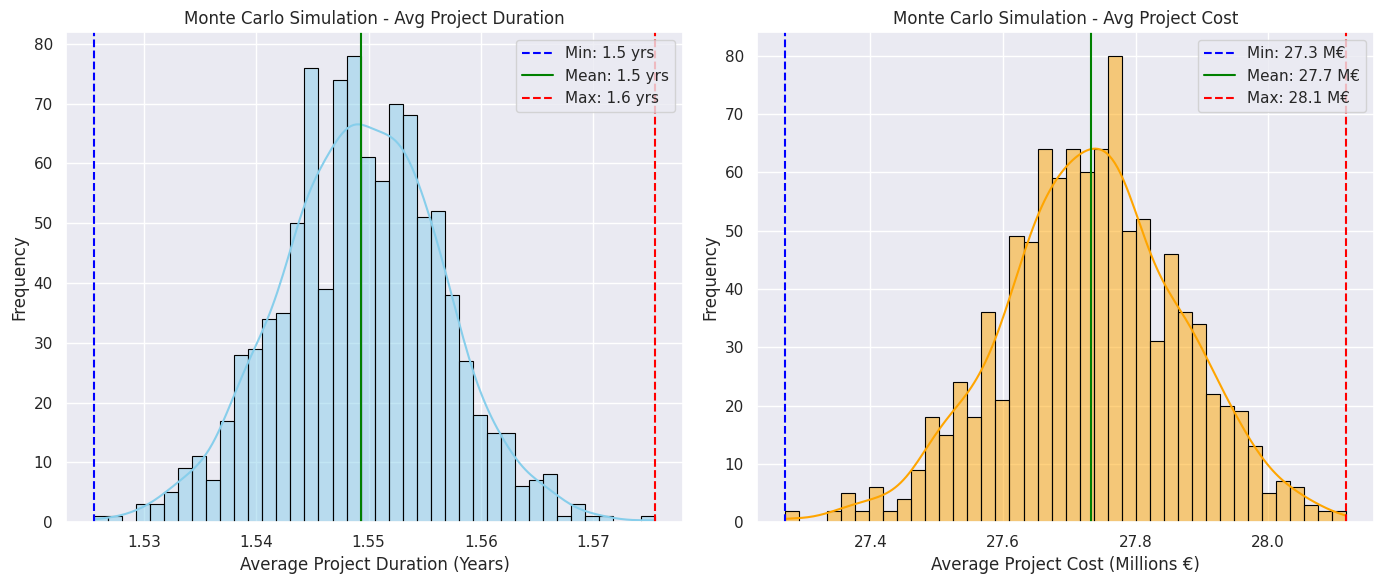

In [ ]:
## STEP 11-1: Monte Carlo Simulation

# Load and clean data
df['Planned_Duration'] = pd.to_numeric(df['Planned_Duration'], errors='coerce')
df['Planned_Cost'] = pd.to_numeric(df['Planned_Cost'], errors='coerce')
df = df.dropna(subset=['Planned_Duration', 'Planned_Cost'])

# Monte Carlo simulation
simulations = 1000
average_durations = []
average_costs = []

for _ in range(simulations):
    sim_durations = []
    sim_costs = []

    for _, row in df.iterrows():
        duration = row['Planned_Duration']
        cost = row['Planned_Cost']

        rand_duration = duration * np.random.uniform(0.8, 1.3)
        rand_cost = cost * np.random.uniform(0.8, 1.3)

        sim_durations.append(rand_duration)
        sim_costs.append(rand_cost)

#calculate the average
    average_durations.append(np.mean(sim_durations))
    average_costs.append(np.mean(sim_costs))

#Numpy arrays
average_durations = np.array(average_durations) / 365
average_costs = np.array(average_costs)

# Statistics
min_d, mean_d, max_d = np.min(average_durations), np.mean(average_durations), np.max(average_durations)
min_c, mean_c, max_c = np.min(average_costs), np.mean(average_costs), np.max(average_costs)

#chart
plt.figure(figsize=(14, 6))

# Duration in Years
plt.subplot(1, 2, 1)
sns.histplot(average_durations, bins=40, kde=True, color='skyblue', edgecolor='black')
plt.axvline(min_d, color='blue', linestyle='--', label=f'Min: {min_d:.1f} yrs')
plt.axvline(mean_d, color='green', linestyle='-', label=f'Mean: {mean_d:.1f} yrs')
plt.axvline(max_d, color='red', linestyle='--', label=f'Max: {max_d:.1f} yrs')
plt.title('Monte Carlo Simulation - Avg Project Duration')
plt.xlabel('Average Project Duration (Years)')
plt.ylabel('Frequency')
plt.legend()

# Cost in Millions €
plt.subplot(1, 2, 2)
sns.histplot(average_costs / 1e6, bins=40, kde=True, color='orange', edgecolor='black')
plt.axvline(min_c / 1e6, color='blue', linestyle='--', label=f'Min: {min_c/1e6:.1f} M€')
plt.axvline(mean_c / 1e6, color='green', linestyle='-', label=f'Mean: {mean_c/1e6:.1f} M€')
plt.axvline(max_c / 1e6, color='red', linestyle='--', label=f'Max: {max_c/1e6:.1f} M€')
plt.title('Monte Carlo Simulation - Avg Project Cost')
plt.xlabel('Average Project Cost (Millions €)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
####


In [ ]:
## STEP 11-2: Monte Carlo Simulation

# Make sure to calculate the project duration and schedule deviation.
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['End_Date'] = pd.to_datetime(df['End_Date'])
df['Planned_Duration'] = pd.to_numeric(df['Planned_Duration'], errors='coerce')
df['Actual_Duration'] = (df['End_Date'] - df['Start_Date']).dt.days
df['Planned_Cost'] = pd.to_numeric(df['Planned_Cost'], errors='coerce')
df['Actual_Cost'] = pd.to_numeric(df['Actual_Cost'], errors='coerce')

# Calculate the deviations
df['Schedule_Deviation'] = df['Actual_Duration'] - df['Planned_Duration']
df['Cost_Overrun'] = df['Actual_Cost'] - df['Planned_Cost']

# We calculate the loss measure = total delay + increase in cost
df['Total_Loss'] = df['Schedule_Deviation'].fillna(0) + (df['Cost_Overrun'].fillna(0) / 10000)  # scale cost

# We consider the worst project
worst_project = df.loc[df['Total_Loss'].idxmax()]


In [ ]:
worst_project = df.loc[df['Total_Loss'].idxmax()]


In [ ]:
## STEP 11-3: Monte Carlo Simulation

print("\n📌 Most Risky Project (Highest Delay + Overrun):")
print(f"Project ID      : {worst_project.get('Project_ID', 'N/A')}")
print(f"Project Type    : {worst_project['Project_Type']}")
print(f"Planned Duration: {worst_project['Planned_Duration']} days")
print(f"Actual Duration : {worst_project['Actual_Duration']} days")
print(f"Planned Cost    : {worst_project['Planned_Cost'] / 1_000_000:.2f} M€")
print(f"Actual Cost     : {worst_project['Actual_Cost'] / 1_000_000:.2f} M€")
print(f"Schedule Deviation: {worst_project['Schedule_Deviation']} days")
print(f"Cost Overrun      : {(worst_project['Actual_Cost'] - worst_project['Planned_Cost']) / 1_000_000:.2f} M€")



📌 Most Risky Project (Highest Delay + Overrun):
Project ID      : PJT_412
Project Type    : Road
Planned Duration: 357 days
Actual Duration : 720 days
Planned Cost    : 46.76 M€
Actual Cost     : 70.03 M€
Schedule Deviation: 363 days
Cost Overrun      : 23.27 M€


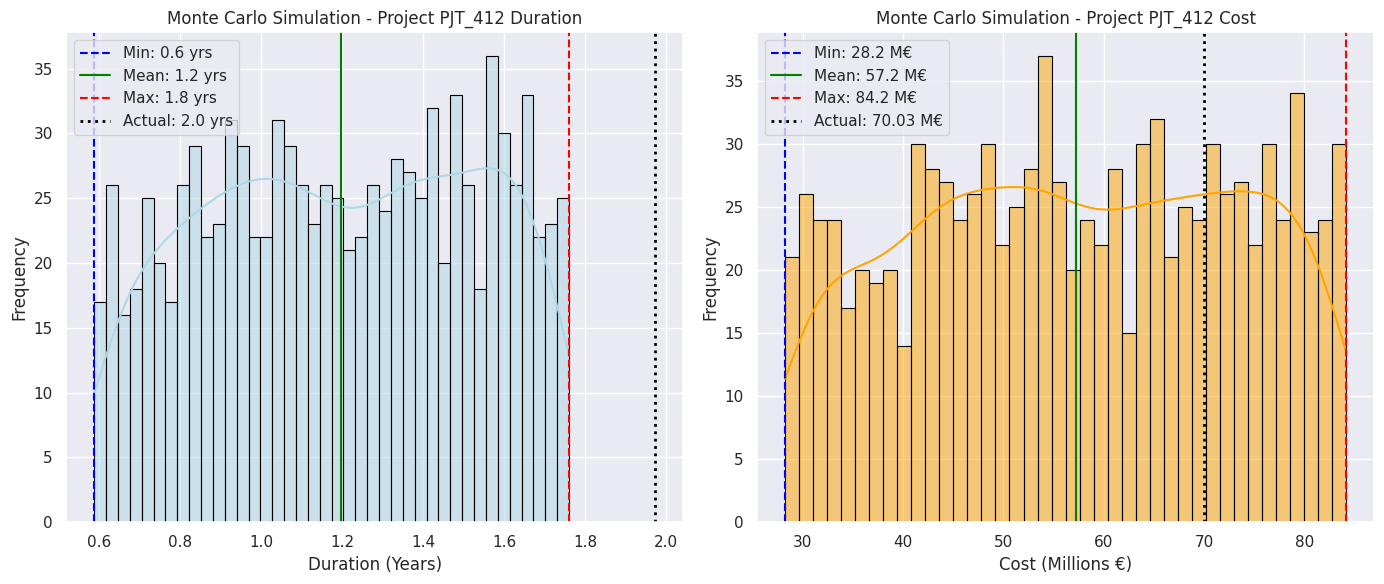

In [ ]:
## STEP 11-4: Monte Carlo Simulation

# Worst Project Data
planned_duration = 357  # days
planned_cost = 46.76 * 1e6  # M€ to €

actual_duration = 720  # days
actual_cost = 70.03 * 1e6  # €

# Number of simulations
simulations = 1000
min_factor = 0.6
max_factor = 1.8

duration_sim = []
cost_sim = []

for _ in range(simulations):
    d = planned_duration * np.random.uniform(min_factor, max_factor)
    c = planned_cost * np.random.uniform(min_factor, max_factor)
    duration_sim.append(d)
    cost_sim.append(c)

# Convert to numpy arrays
duration_sim = np.array(duration_sim) / 365
cost_sim = np.array(cost_sim)

# Convert actual to years and million €
actual_duration_yrs = actual_duration / 365
actual_cost_millions = actual_cost / 1e6

# statistics
min_d, mean_d, max_d = np.min(duration_sim), np.mean(duration_sim), np.max(duration_sim)
min_c, mean_c, max_c = np.min(cost_sim), np.mean(cost_sim), np.max(cost_sim)

#chart
plt.figure(figsize=(14, 6))

#Figure 1: Duration in years
plt.subplot(1, 2, 1)
sns.histplot(duration_sim, bins=40, kde=True, color='lightblue', edgecolor='black')
plt.axvline(min_d, color='blue', linestyle='--', label=f'Min: {min_d:.1f} yrs')
plt.axvline(mean_d, color='green', linestyle='-', label=f'Mean: {mean_d:.1f} yrs')
plt.axvline(max_d, color='red', linestyle='--', label=f'Max: {max_d:.1f} yrs')
plt.axvline(actual_duration_yrs, color='black', linestyle=':', linewidth=2, label=f'Actual: {actual_duration_yrs:.1f} yrs')
plt.title('Monte Carlo Simulation - Project PJT_412 Duration')
plt.xlabel('Duration (Years)')
plt.ylabel('Frequency')
plt.legend()

#Figure 2: Cost in millions
plt.subplot(1, 2, 2)
sns.histplot(cost_sim / 1e6, bins=40, kde=True, color='orange', edgecolor='black')
plt.axvline(min_c / 1e6, color='blue', linestyle='--', label=f'Min: {min_c/1e6:.1f} M€')
plt.axvline(mean_c / 1e6, color='green', linestyle='-', label=f'Mean: {mean_c/1e6:.1f} M€')
plt.axvline(max_c / 1e6, color='red', linestyle='--', label=f'Max: {max_c/1e6:.1f} M€')
plt.axvline(actual_cost_millions, color='black', linestyle=':', linewidth=2, label=f'Actual: {actual_cost_millions:.2f} M€')
plt.title('Monte Carlo Simulation - Project PJT_412 Cost')
plt.xlabel('Cost (Millions €)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
## STEP 12-1: Accident Summary

print("📊 Accident Summary:")
print(df['Accident_Count'].describe())

print("\n🚧 Projects with most accidents:")
print(df[['Project_ID', 'Project_Type', 'Accident_Count']].sort_values('Accident_Count', ascending=False).head(10))


📊 Accident Summary:
count    1000.000000
mean        4.567000
std         2.878854
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max         9.000000
Name: Accident_Count, dtype: float64

🚧 Projects with most accidents:
    Project_ID Project_Type  Accident_Count
371    PJT_372       Tunnel               9
373    PJT_374     Building               9
384    PJT_385          Dam               9
436    PJT_437         Road               9
439    PJT_440       Bridge               9
931    PJT_932       Bridge               9
40      PJT_41       Tunnel               9
946    PJT_947         Road               9
959    PJT_960       Bridge               9
961    PJT_962         Road               9


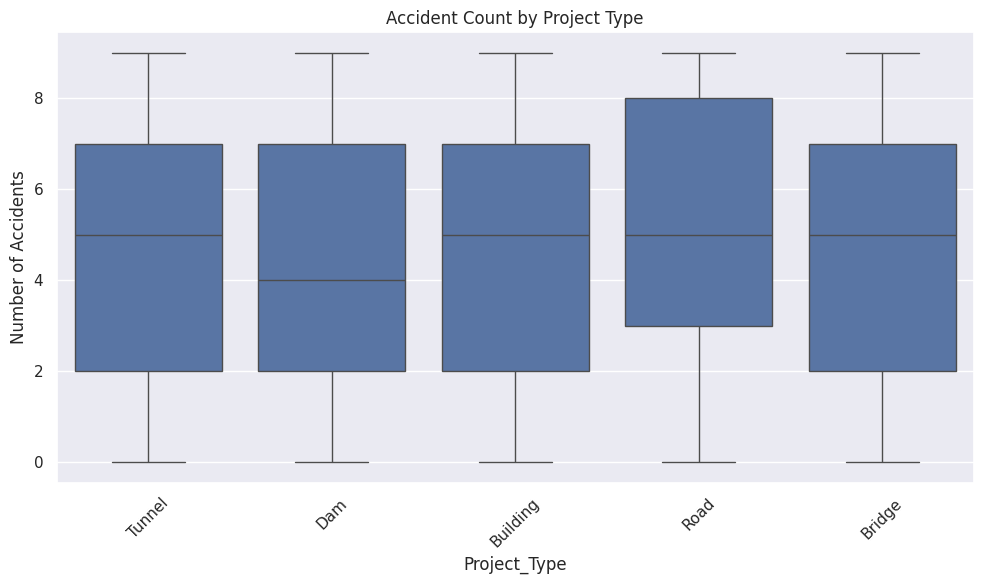

In [ ]:
## STEP 12-2: Accident Summary

plt.figure(figsize=(10, 6))
sns.boxplot(x='Project_Type', y='Accident_Count', data=df)
plt.xticks(rotation=45)
plt.title("Accident Count by Project Type")
plt.ylabel("Number of Accidents")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
